# Impact Studies Using SuPy in Parallel Mode

## Aim

In this tutorial, we aim to perform sensitivity analysis using `supy` in a parallel mode to investigate the impacts on urban climate of

1. surface properties: the physical attributes of land covers (e.g., albedo, water holding capacity, etc.)
2. background climate: longterm meteorological conditions (e.g., air temperature, precipitation, etc.)



## Prepare `supy` for the parallel mode

### load `supy` and sample dataset

In [1]:
from dask import delayed
from dask import dataframe as dd
import os
import supy as sp
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import time

get_ipython().run_line_magic('matplotlib', 'inline')
print('version info:')
print('supy:', sp.__version__)
print('supy_driver:', sp.__version_driver__)



version info:
supy: 2019.1.1
supy_driver: 2018b20


In [2]:
# load sample datasets
df_state_init, df_forcing = sp.load_SampleData()
# perform an example run to get output samples for later use
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init)

### Paralell setup for `supy` using `dask`

In addition to the above packages, we also load `dask` to enable `supy` run in a parallel mode. Specifically, we will use [`dask.dataframe`](http://docs.dask.org/en/latest/dataframe.html), a specialised `dataframe` extending `pandas.DataFrame`'s ability in parallel operations, to implement a parallel `supy` for the impact studies in this tutorial.

Given the nature of impact studies that requires multiple independent models with selected parameters/variables varying across the setups, such simulations well fall into the scope of so-called [*embarrassingly parallel computation*](http://docs.dask.org/en/latest/use-cases.html#embarrassingly-parallel-computation) that is fully supported by `dask`. Also, as `supy` is readily built on the data structure `pandas.DataFrame`, we can fairly easily transfer it to the `dask` framework for parallel operations.

Internally, for a given forcing dataset `df_forcing`, `supy` loops over the grids in a `df_state_init` to conduct simulations. In this case, we can adapt the `df_state_init` to a `dask`-ed version to gain the parallel benifits through its parallelised `apply` method.

`dask.dataframe` essentially divides the work into pieces for parallel operations. As such, depending on the number of processors in your computer, it would be more efficient to set the partition number as the multipliers of CPU numbers.

In [3]:
print(os.cpu_count())


12


To demonstrate the parallelisation, we simply duplicate the contents in `df_state_init` to make it seemingly large. Note we intentionally choose `24` as the number for copies to accompany the power of CPU.

Before we move on to the paralell mode, we perform a simulation in the traditional serial way to see the baseline performance.

#### Baseline serial  run

In [4]:
# just run for 30 days
df_forcing_part = df_forcing.iloc[:288*30]
df_state_init_mgrids = df_state_init.copy()
# construct a multi-grid `df_state_init`
for i in range(24-1):
    df_state_init_mgrids = df_state_init_mgrids.append(
        df_state_init, ignore_index=True)
# perform a serial run
t0 = time()
xx = sp.run_supy(df_forcing_part, df_state_init_mgrids)
t1 = time()
t_ser = t1-t0
print(f'Execution time: {t_ser:.2f} s')


Execution time: 30.42 s


#### Parallel  run

In [5]:
# convert `pandas.DataFrame` to `dask.dataframe` to enable parallelisation
dd_state_init = dd.from_pandas(
    df_state_init_mgrids,
    npartitions=os.cpu_count()*2)

# perform a parallel run using `map_partitions`
t0 = time()
xx_mp = dd_state_init    .map_partitions(
        lambda x: sp.run_supy(df_forcing_part, x)[0],
        meta=df_output)\
    .compute(scheduler='processes')
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')
xx_mp.head()



Execution time: 7.25 s


group                        SUEWS                                             \
var                          Kdown     Kup       Ldown         Lup      Tsurf   
grid datetime                                                                   
0    2012-01-01 00:05:00  0.153333  0.0184  344.310184  372.270369  11.775916   
     2012-01-01 00:10:00  0.153333  0.0184  344.310184  372.270369  11.775916   
     2012-01-01 00:15:00  0.153333  0.0184  344.310184  372.270369  11.775916   
     2012-01-01 00:20:00  0.153333  0.0184  344.310184  372.270369  11.775916   
     2012-01-01 00:25:00  0.153333  0.0184  344.310184  372.270369  11.775916   

group                                                               ...  \
var                              QN   QF         QS         QH   QE ...   
grid datetime                                                       ...   
0    2012-01-01 00:05:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   
     2012-01-01 00:10:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   
     2012-01-01 00:15:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   
     2012-01-01 00:20:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   
     2012-01-01 00:25:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   

group                        DailyState                                \
var                      DensSnow_Paved DensSnow_Bldgs DensSnow_EveTr   
grid datetime                                                           
0    2012-01-01 00:05:00            NaN            NaN            NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN   

group                                                                  \
var                      DensSnow_DecTr DensSnow_Grass DensSnow_BSoil   
grid datetime                                                           
0    2012-01-01 00:05:00            NaN            NaN            NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN   

group                                                
var                      DensSnow_Water  a1  a2  a3  
grid datetime                                        
0    2012-01-01 00:05:00            NaN NaN NaN NaN  
     2012-01-01 00:10:00            NaN NaN NaN NaN  
     2012-01-01 00:15:00            NaN NaN NaN NaN  
     2012-01-01 00:20:00            NaN NaN NaN NaN  
     2012-01-01 00:25:00            NaN NaN NaN NaN  

[5 rows x 218 columns]

In [6]:
# perform a parallel run using `apply`
t0 = time()
xx_apply = dd_state_init    .apply(
        lambda x: sp.run_supy(df_forcing_part, x.to_frame().T)[0],
        axis=1,
        meta=df_output.iloc[0])\
    .compute(scheduler='processes')
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')
# note the difference in resulted data structure between `xx_apply` and `xx_mp`
xx_apply.head()


Execution time: 10.42 s


0    group                        SUEWS            ...
1    group                        SUEWS            ...
2    group                        SUEWS            ...
3    group                        SUEWS            ...
4    group                        SUEWS            ...
Name: (1, 2012-01-01 00:05:00), dtype: object

#### wrap up the above code into a function for easier use in multi-grid simulations


In [7]:
# function for multi-grid `run_supy` using map_partitions for better performance
def run_supy_mgrids(df_state_init_mgrids, df_forcing):
    dd_state_init = dd.from_pandas(
        df_state_init_mgrids,
        npartitions=os.cpu_count()*2)
    df_output_mgrids = dd_state_init        .map_partitions(
            lambda x: sp.run_supy(df_forcing, x)[0],
            meta=df_output)\
        .compute(scheduler='processes')
    return df_output_mgrids


## Surface properties

### Surface albedo

#### Let's examine the default albedo values loaded from the sample dataset

In [8]:
df_state_init.alb


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.12,0.15,0.12,0.18,0.21,0.21,0.1


#### Copy the initial condition `DataFrame`  to have a *clean slate* for our study

*Note: `DataFrame.copy()` defaults to `deepcopy`*

In [9]:
df_state_init_test = df_state_init.copy()


#### Set the `Bldg` land cover to 100% for this study

In [10]:
df_state_init_test.sfr = 0
df_state_init_test.loc[:, ('sfr', '(1,)')] = 1
df_state_init_test.sfr


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0,1,0,0,0,0,0


#### Construct a `df_state_init_x` dataframe to perform `supy` simulation with specified albedo

In [11]:
n_test = 24
list_alb_test = np.linspace(0.1, 0.8, n_test).round(2)
df_state_init_x = df_state_init_test.append(
    [df_state_init_test]*(n_test-1), ignore_index=True)
df_state_init_x.loc[:, ('alb', '(1,)')] = list_alb_test


#### Conduct simulations with `supy`

In [12]:
df_forcing_part = df_forcing.loc['2012 07']
df_res_alb_test = run_supy_mgrids(
    df_state_init_x, df_forcing_part)
df_res_alb_test.head()



group                    SUEWS                                          \
var                      Kdown  Kup       Ldown         Lup      Tsurf   
grid datetime                                                            
0    2012-07-01 00:00:00   0.0  0.0  343.371100  380.097776  13.660833   
     2012-07-01 00:05:00   0.0  0.0  343.383128  380.090742  13.659167   
     2012-07-01 00:10:00   0.0  0.0  343.395156  380.083708  13.657500   
     2012-07-01 00:15:00   0.0  0.0  343.407185  380.076675  13.655833   
     2012-07-01 00:20:00   0.0  0.0  343.419215  380.069642  13.654167   

group                                                              ...  \
var                              QN   QF         QS        QH   QE ...   
grid datetime                                                      ...   
0    2012-07-01 00:00:00 -36.726676  0.0 -33.282094 -3.444582  0.0 ...   
     2012-07-01 00:05:00 -36.707614  0.0 -33.275523 -3.432092  0.0 ...   
     2012-07-01 00:10:00 -36.688552  0.0 -33.268951 -3.419601  0.0 ...   
     2012-07-01 00:15:00 -36.669490  0.0 -33.262379 -3.407110  0.0 ...   
     2012-07-01 00:20:00 -36.650427  0.0 -33.255807 -3.394619  0.0 ...   

group                        DailyState                                \
var                      DensSnow_Paved DensSnow_Bldgs DensSnow_EveTr   
grid datetime                                                           
0    2012-07-01 00:00:00            NaN            NaN            NaN   
     2012-07-01 00:05:00            NaN            NaN            NaN   
     2012-07-01 00:10:00            NaN            NaN            NaN   
     2012-07-01 00:15:00            NaN            NaN            NaN   
     2012-07-01 00:20:00            NaN            NaN            NaN   

group                                                                  \
var                      DensSnow_DecTr DensSnow_Grass DensSnow_BSoil   
grid datetime                                                           
0    2012-07-01 00:00:00            NaN            NaN            NaN   
     2012-07-01 00:05:00            NaN            NaN            NaN   
     2012-07-01 00:10:00            NaN            NaN            NaN   
     2012-07-01 00:15:00            NaN            NaN            NaN   
     2012-07-01 00:20:00            NaN            NaN            NaN   

group                                                
var                      DensSnow_Water  a1  a2  a3  
grid datetime                                        
0    2012-07-01 00:00:00            NaN NaN NaN NaN  
     2012-07-01 00:05:00            NaN NaN NaN NaN  
     2012-07-01 00:10:00            NaN NaN NaN NaN  
     2012-07-01 00:15:00            NaN NaN NaN NaN  
     2012-07-01 00:20:00            NaN NaN NaN NaN  

[5 rows x 218 columns]

In [13]:
ind_alb = df_res_alb_test.index    .set_levels(list_alb_test, level=0)    .set_names('alb', level=0)
df_res_alb_test.index = ind_alb
df_res_alb_test = df_res_alb_test.SUEWS.unstack(0)


#### Examine the results

Text(0.5, 0, 'Albedo')

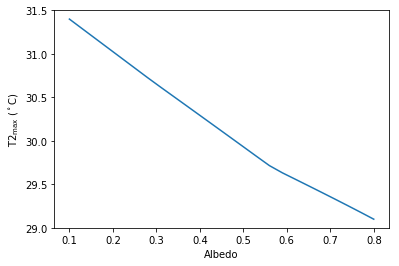

In [14]:
ax_T2max = df_res_alb_test.T2.describe().loc['max'].rename(
    'T2max').plot(ylim=(29, 31.5), color='tab:blue')
ax_T2max.set_ylabel('T2$\mathrm{_{max}}$ ($^\circ$C)')
ax_T2max.set_xlabel('Albedo')



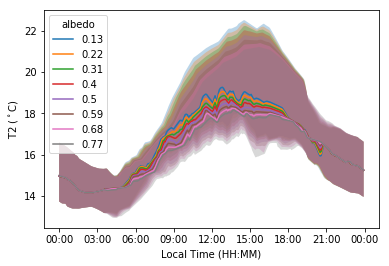

In [15]:
fig_T2, ax_T2 = sp.plot_day_clm(
    df_res_alb_test.T2.loc['2012 7'].iloc[:, 1:-1:3])
ax_T2.set_ylabel('T2 ($^\circ$C)')
ax_T2.set_xlabel('Local Time (HH:MM)')
ax_T2.legend(title='albedo')


### Soil water holding capacity

#### Let's examine the default `soilstorecap` related values loaded from the sample dataset

In [16]:
df_state_init.filter(like='soilstore').T


grid                      1
var          ind_dim       
soilstore_id (0,)     150.0
             (1,)     150.0
             (2,)     150.0
             (3,)     150.0
             (4,)     150.0
             (5,)     150.0
             (6,)       0.0
soilstorecap (0,)     150.0
             (1,)     150.0
             (2,)     150.0
             (3,)     150.0
             (4,)     150.0
             (5,)     150.0
             (6,)       0.0

We can see all the soil stores are saturated at the beginning.

#### Copy the initial condition `DataFrame`  to have a *clean slate* for our study

*Note: `DataFrame.copy()` defaults to `deepcopy`*

In [17]:
df_state_init_test = df_state_init.copy()


#### Set equal cover fractions for this study

In [18]:
df_state_init_test.sfr = 1/df_state_init_test.sfr.size
df_state_init_test.sfr


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


#### Construct a `test_soilstorecap` function to perform `supy` simulation with specified `soilstorecap`

#### Construct `df_state_init_x` with store capacity values to test

In [19]:
n_test = 24
list_soilstorecap_test = np.linspace(10, 20, n_test).round(2)
df_state_init_x = df_state_init_test.append(
    [df_state_init_test]*(n_test-1), ignore_index=True)
df_state_init_x.loc[:, 'soilstorecap'] = np.repeat(
    [list_soilstorecap_test], 7, axis=0).T


#### Conduct simulations with `supy`

In [20]:
df_forcing_part = df_forcing.loc['2012 07']
df_res_soilstorecap_test = run_supy_mgrids(
    df_state_init_x, df_forcing_part)


#### Examine the results

In [21]:
ind_soilstorecap = df_res_soilstorecap_test.index    .set_levels(list_soilstorecap_test, level=0)    .set_names('soilstorecap', level=0)
df_res_soilstorecap_test.index = ind_soilstorecap
df_res_soilstorecap_test = df_res_soilstorecap_test.SUEWS.unstack(0)



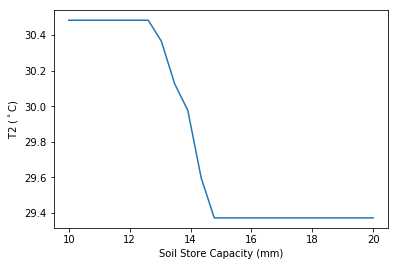

In [22]:
df_res_soilstorecap_test_stat = df_res_soilstorecap_test.describe()
ax_t2m = df_res_soilstorecap_test_stat.loc['max', 'T2'].plot()
ax_t2m.set_ylabel('T2 ($^\circ$C)')
ax_t2m.set_xlabel('Soil Store Capacity (mm)')
ax_t2m



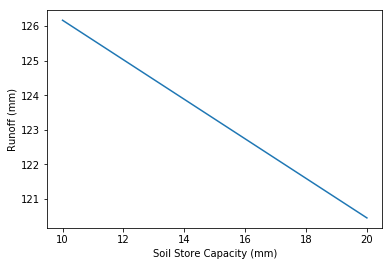

In [23]:
ax_RO = df_res_soilstorecap_test.RO.sum().plot()
ax_RO.set_ylabel('Runoff (mm)')
ax_RO.set_xlabel('Soil Store Capacity (mm)')
ax_RO



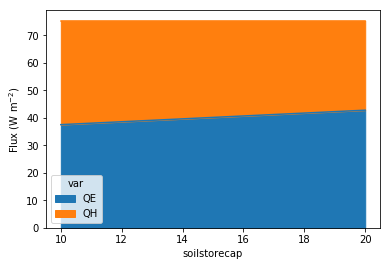

In [24]:
ax_flux = df_res_soilstorecap_test.describe().loc['mean'].unstack(
    0).loc[:, ['QE', 'QH']].plot.area(sort_columns=True)
ax_flux.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
ax_flux


## Background climate

### Air temperature

#### Let's examine the monthly climatology of air temperature loaded from the sample dataset

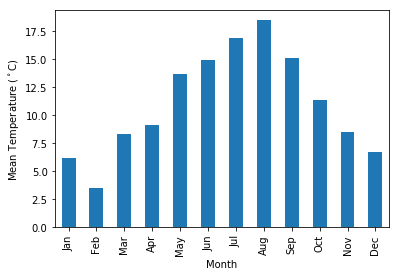

In [25]:
df_plot = df_forcing.Tair.iloc[:-1].resample('1m').mean()
ax_temp = df_plot.plot.bar(color='tab:blue')
ax_temp.set_xticklabels(df_plot.index.strftime('%b'))
ax_temp.set_ylabel('Mean Temperature ($^\circ$C)')
ax_temp.set_xlabel('Month')
ax_temp


#### Construct a function to perform parallel `supy` simulation with specified `diff_airtemp_test`: the difference in air temperature between the one used in simulation and loaded from sample dataset.
*Note: forcing data `df_forcing` has different data sturcture from `df_state_init`; so we need to modify `run_supy_mgrids` to implement a `run_supy_mclims` for different climate scenarios*

Let's start the implementation of `run_supy_mclims` with a small prblem of four forcing groups (i.e., climate scerios), where the air temperatures differ from the baseline scenario with a constant bias.

In [26]:
df_forcing_part_test = df_forcing.loc['2012 7'].copy()
df_state_init_test = df_state_init.copy()



In [27]:
n_test = 4
list_TairDiff_test = np.linspace(0.2, 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy()
    for tairdiff in list_TairDiff_test}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, 'Tair'] += tairdiff

dd_forcing_x = {
    k: delayed(sp.run_supy)(df, df_state_init_test)[0]
    for k, df in dict_df_forcing_x.items()}


df_res_tairdiff_test0 = delayed(pd.concat)(
    dd_forcing_x,
    keys=list_TairDiff_test,
    names=['tairdiff'],
)



In [28]:
# dict_df_forcing_x
# df_res_tairdiff_test0.visualize()
t0 = time()
df_res_tairdiff_test=df_res_tairdiff_test0    .compute(scheduler='processes')    .reset_index('grid', drop=True)
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')



Execution time: 3.71 s


In [29]:
# function for multi-climate `run_supy`
def run_supy_mclims(df_state_init, dict_df_forcing_mclims):
    dd_forcing_x = {
        k: delayed(sp.run_supy)(df, df_state_init_test)[0]
        for k, df in dict_df_forcing_x.items()}
    df_output_mclims0 = delayed(pd.concat)(
        dd_forcing_x,
        keys=list(dict_df_forcing_x.keys()),
        names=['clm'],
    ).compute(scheduler='processes')
    df_output_mclims = df_output_mclims0.reset_index('grid', drop=True)

    return df_output_mclims



#### Construct `dict_df_forcing_x` to test and perform simulations with `supy`

In [30]:
df_forcing_part_test = df_forcing.loc['2012 7'].copy()
df_state_init_test = df_state_init.copy()

n_test = 24
list_TairDiff_test = np.linspace(0.2, 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy()
    for tairdiff in list_TairDiff_test}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, 'Tair'] += tairdiff

t0 = time()
df_airtemp_test_x = run_supy_mclims(df_state_init, dict_df_forcing_x)
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')


Execution time: 14.11 s


#### Examine the results

In [31]:
df_airtemp_test = df_airtemp_test_x.SUEWS.unstack(0)



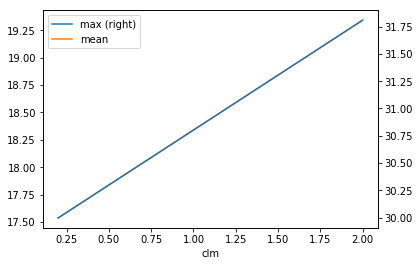

In [32]:
df_airtemp_test.T2.describe().loc[['max', 'mean', ]].T.plot(
    secondary_y=['max'])



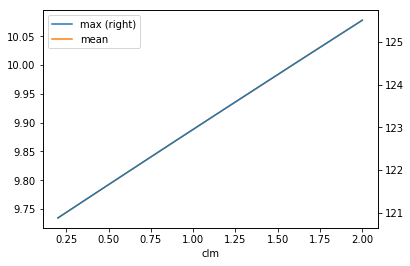

In [33]:
df_airtemp_test.QE.describe().loc[['max', 'mean', ]].T.plot(
    secondary_y=['max'])



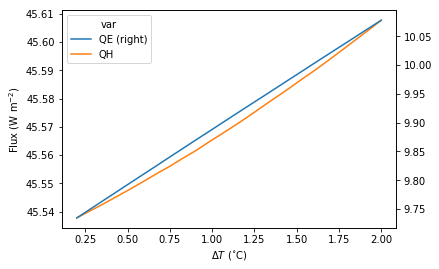

In [34]:
df_flux = df_airtemp_test.loc[:, ['QH', 'QE']]    .describe().loc[['max', 'mean', ]]    .stack(1).unstack(0).swaplevel(1, 0, axis=1).loc[:, 'mean']
ax_flux = df_flux.plot(secondary_y='QE')
ax_flux.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
ax_flux.set_xlabel('$\Delta T$ ($^{\circ}}$C)')
ax_flux


### Precipitation

#### Let's examine the charaterisitcs of precipitation loaded from the sample dataset

Monthly total precipitation:

Text(0, 0.5, 'Precipitation (mm)')

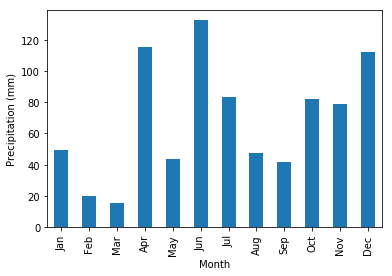

In [35]:
df_plot = df_forcing.rain.iloc[:-1].resample('1m').sum()
ax_precip = df_plot.plot.bar(color='tab:blue')
ax_precip.set_xticklabels(df_plot.index.strftime('%b'))
ax_precip.set_xlabel('Month')
ax_precip.set_ylabel('Precipitation (mm)')


Daily total precipitation of July 2012:

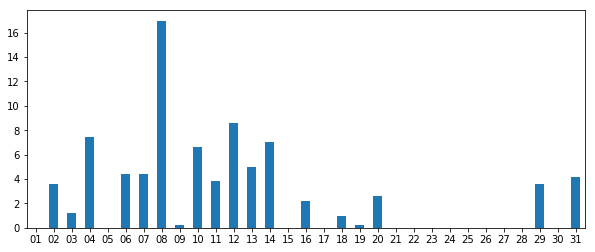

In [36]:
df_plot = df_forcing.rain.loc['2012 7'].resample('1d').sum()
ax_precip = df_plot.plot.bar(color='tab:blue', figsize=(10, 4))
ax_precip.set_xticklabels(df_plot.index.strftime('%d'), rotation=0)
ax_precip


Look into a 3-hour period of 2012-Jul-8:

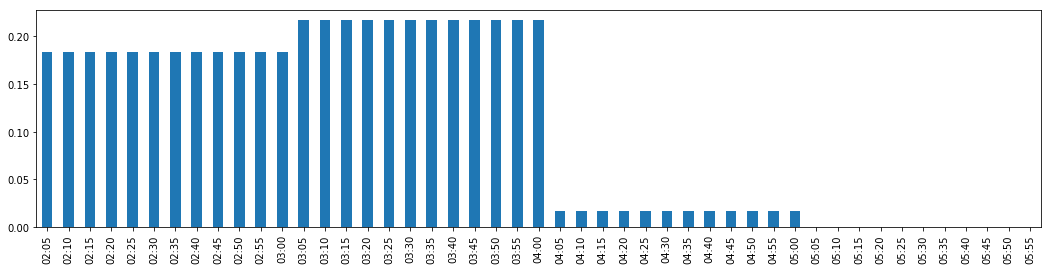

In [37]:
ser_plot = df_forcing.rain.loc['2012 7 8 0205':'2012 7 8 05']
ax_precip = ser_plot.plot.bar(color='tab:blue', figsize=(18, 4))
ax_precip.set_xticklabels(ser_plot.index.strftime('%H:%M'), rotation=90)
ax_precip


#### Construct `redist_precip` to randomly redistribute precipiation within the input period

In [38]:
def redist_precip(ser_precip, n):
    # keep the original data by .copy()
    ser_precip_redist = ser_precip.copy()
    # get series length
    len_ser = ser_precip_redist.size
    # generate a series with n random values and others filled as zeros
    n_sample = np.pad(np.random.rand(n), (0, len_ser), 'constant',
                      constant_values=(0))[:len_ser]
    # normalise `ser_precip_redist` with according to `n_sample`
    ser_precip_redist = ser_precip_redist.sum()*n_sample/n_sample.sum()
    # reshuffle for random locations
    np.random.shuffle(ser_precip_redist)
    return ser_precip_redist


#### Examine the redistributed precipiation in a comparison with the evenly distributed results

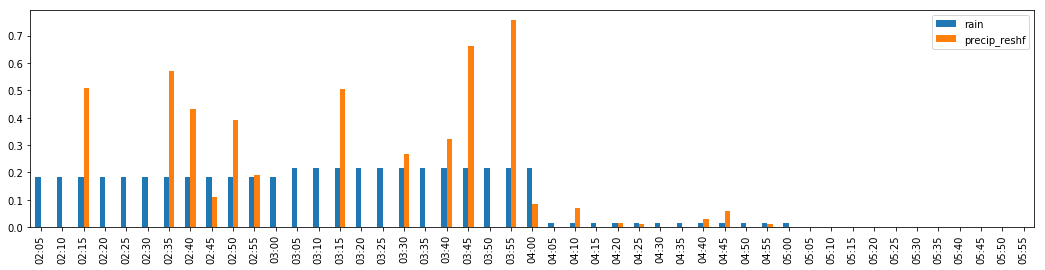

In [39]:
ser_plot_reshf = ser_plot.copy()    .resample('60T', closed='right', label='right')    .transform(redist_precip, n=6).rename('precip_reshf')
df_precip = pd.concat([ser_plot, ser_plot_reshf], axis=1)
ax_precip = df_precip.plot.bar(figsize=(18, 4))
ax_precip.set_xticklabels(df_precip.index.strftime('%H:%M'), rotation=90)
ax_precip


#### Generate a range of precipitation series of different redistribution patterns

In [40]:
ser_precip_orig = df_forcing.rain.loc['2012 7']
grp_precip_orig = ser_precip_orig.copy().resample(
    '60T', closed='right', label='right')
df_precip_reshf = pd.concat(
    {n_dist: grp_precip_orig.transform(redist_precip, n=n_dist)
     for n_dist in np.arange(1, 13)},
    axis=1)



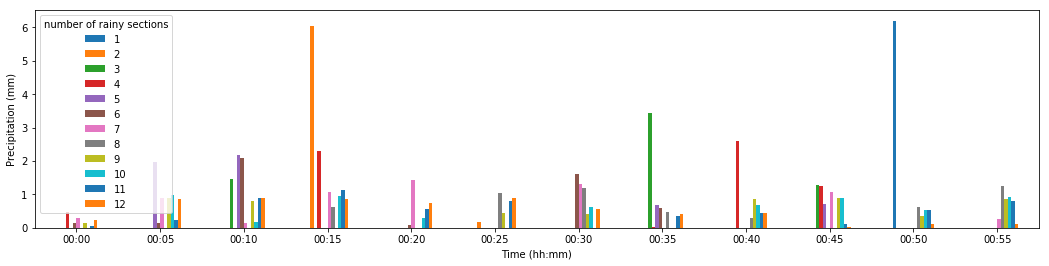

In [41]:
ax_precip = df_precip_reshf.loc['2012 7 8 00'].plot.bar(figsize=(18, 4), rot=0)
ax_precip.set_xticklabels(df_precip_reshf.index.strftime('%H:%M'), rotation=0)
ax_precip.legend(title='number of rainy sections')
ax_precip.set_xlabel('Time (hh:mm)')
ax_precip.set_ylabel('Precipitation (mm)')
ax_precip


#### Construct a `test_precip_n` function to perform `supy` simulation with specified `n_dist`

In [42]:
df_forcing_part_test = df_forcing.loc['2012 7'].copy()
df_state_init_test = df_state_init.copy()

list_ndist_test = df_precip_reshf.columns
dict_df_forcing_x = {
    ndist: df_forcing_part_test.copy()
    for ndist in list_ndist_test}
for ndist in dict_df_forcing_x:
    dict_df_forcing_x[ndist]['rain'] = df_precip_reshf[ndist]

t0 = time()
df_ndist_test_x = run_supy_mclims(df_state_init, dict_df_forcing_x)
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')


Execution time: 7.47 s


#### Examine the results

In [43]:
df_ndist_test_x.head()
df_precip_test = df_ndist_test_x.SUEWS.unstack(0)



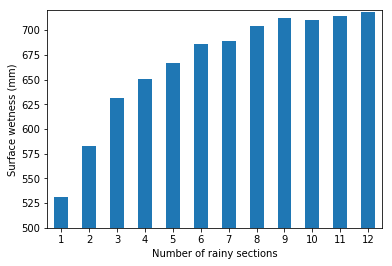

In [44]:

ax_state = df_precip_test.NWtrState.sum().plot.bar(
    ylim=(500, 720), color='tab:blue', rot=0)
ax_state.set_xlabel('Number of rainy sections')
ax_state.set_ylabel('Surface wetness (mm)')
ax_state



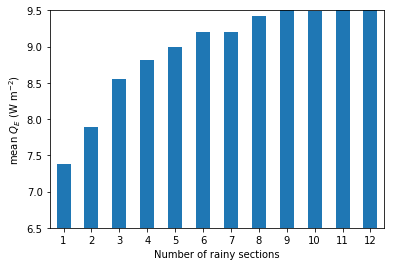

In [45]:
ax_QE = df_precip_test.QE.describe().loc['mean'].plot.bar(
    ylim=(6.5, 9.5), color='tab:blue', rot=0)
ax_QE.set_xlabel('Number of rainy sections')
ax_QE.set_ylabel('mean $Q_E$ ($ \mathrm{W \ m^{-2}}$)')
ax_QE



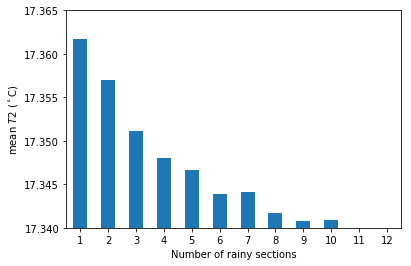

In [46]:
ax_T2 = df_precip_test.T2.describe().loc['mean'].plot.bar(
    ylim=(17.34, 17.365), color='tab:blue', rot=0)
ax_T2.set_xlabel('Number of rainy sections')
ax_T2.set_ylabel('mean $T2$ ($^\circ$C)')
ax_T2


